In [1]:
!pip install prophet
import prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import holidays
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import ParameterGrid

1685


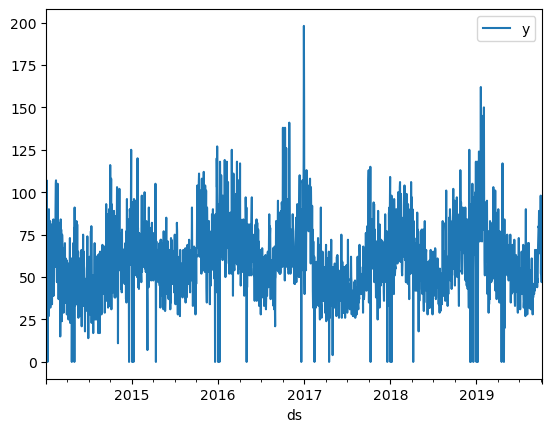

In [2]:
df = pd.read_csv("Datasets/Pharmacy/salesdaily.csv")
sales = (df.M01AB + df.M01AE + df.N02BA + df.N02BE + df.N05B + df.N05C + df.R03 + df.R06)
sales //= 1
df['sales'] = sales
df = df[["datum","sales"]]

df.columns=['ds','y']
df.dropna(inplace=True)
df['ds']=pd.to_datetime(df.ds)
df.plot(x='ds',y='y')

l = len(df)
#2106
dist = round(l*0.8)
train=df[:dist]
test=df[dist:]
print(dist)

10:51:49 - cmdstanpy - INFO - Chain [1] start processing
10:51:50 - cmdstanpy - INFO - Chain [1] done processing


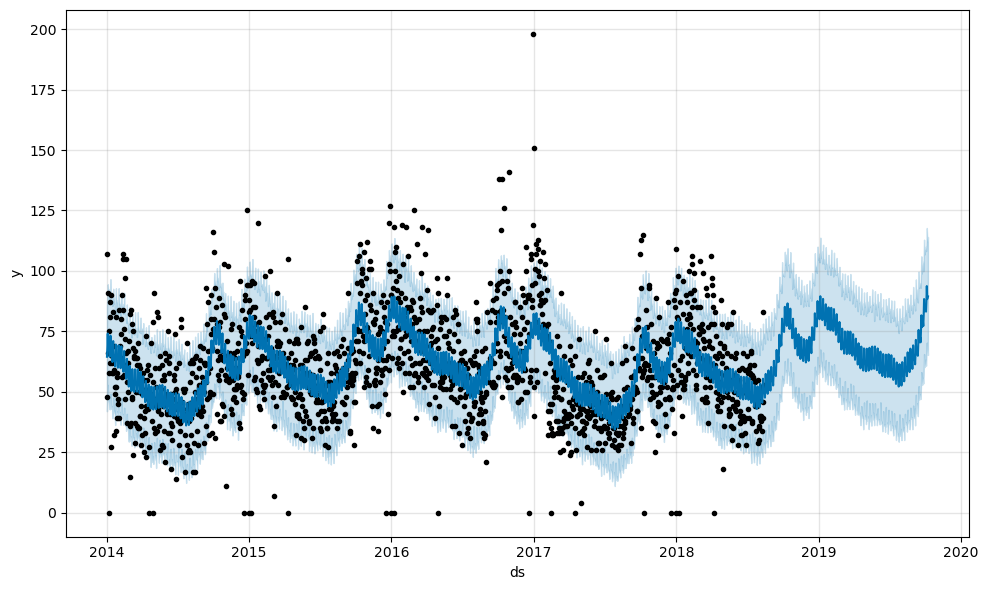

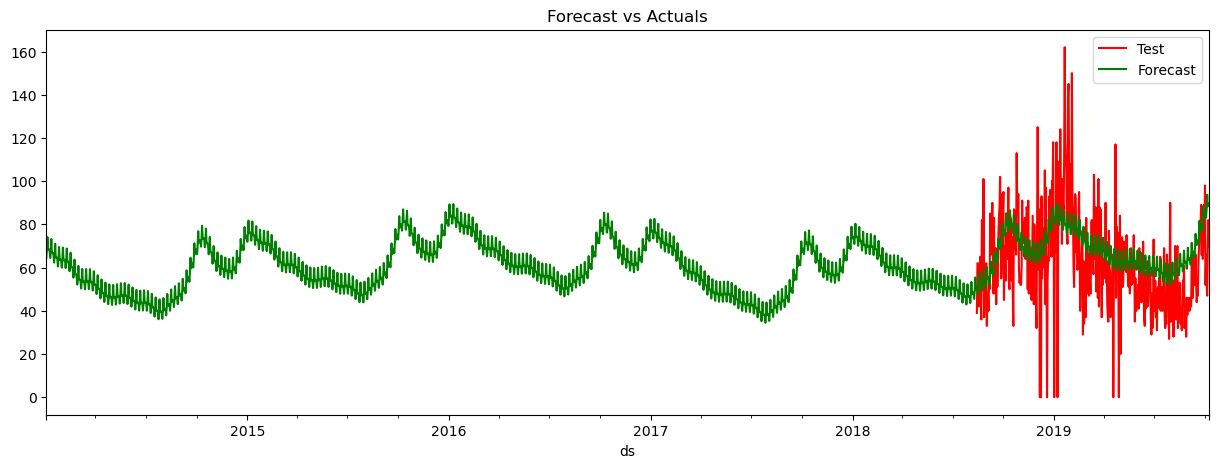

In [3]:
m=Prophet(daily_seasonality=True)
m.fit(train)
future=m.make_future_dataframe(periods=len(test),freq='D')
forecast=m.predict(future)
forecast.head()
m.plot(forecast, uncertainty=True)

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [4]:
#TODO: Drop outliers: D = (value-yhat_upper/value) All data points with D&gt;0.8 (for N02BE D&gt;0.75, for N05C D&gt;0.9) are then treated as outliers and replaced with NaN

In [5]:
holiday_forecast=forecast[len(train):]
mean_absolute_error(test.y, holiday_forecast.yhat)

16.452728959305862

In [6]:
import pandas as pd
import holidays

holiday = pd.DataFrame([])

for date, name in sorted(holidays.UnitedStates(years=[2014, 2015, 2016, 2017, 2018, 2019, 2020]).items()):
    # Create a DataFrame for the current holiday
    current_holiday = pd.DataFrame({'ds': [date], 'holiday': ["US-Holidays"]})
    
    # Concatenate it with the main DataFrame
    holiday = pd.concat([holiday, current_holiday], ignore_index=True)

# Convert the 'ds' column to datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200,]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)


Total Possible Models 150


In [7]:
strt='2014-1-1'
end='2019-08-10'
model_parameters = pd.DataFrame(columns=['MAE', 'Parameters'])

for p in grid:
    print(p)
    random.seed(0)
    train_model = Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                          holidays_prior_scale=p['holidays_prior_scale'],
                          n_changepoints=p['n_changepoints'],
                          seasonality_mode=p['seasonality_mode'],
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          yearly_seasonality=True,
                          holidays=holiday, 
                          interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    
    train_forecast = train_model.make_future_dataframe(periods=len(test), freq='D', include_history=False)
    train_forecast = train_model.predict(train_forecast)
    t_test = train_forecast[['ds', 'yhat']]
    
    Actual = df[(df['ds'] > strt) & (df['ds'] <= end)]
    MAE = mean_absolute_error(test['y'], t_test['yhat'])
    print('Mean Absolute Error(MAE)------------------------------------', MAE)
    
    # Convert the parameters dictionary to a string representation for storing in DataFrame
    parameters_str = str(p)
    
    current_model_parameters = pd.DataFrame({'MAE': [MAE], 'Parameters': [parameters_str]})
    model_parameters = pd.concat([model_parameters, current_model_parameters], ignore_index=True)


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:51:52 - cmdstanpy - INFO - Chain [1] start processing
10:51:53 - cmdstanpy - INFO - Chain [1] done processing
10:51:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.483554075270487
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:51:54 - cmdstanpy - INFO - Chain [1] done processing
10:51:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.893126423970887
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:51:55 - cmdstanpy - INFO - Chain [1] done processing
10:51:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.14040528956608
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:51:56 - cmdstanpy - INFO - Chain [1] done processing
10:51:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.7143693725411
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:51:57 - cmdstanpy - INFO - Chain [1] done processing
10:51:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.825238800376425
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:51:58 - cmdstanpy - INFO - Chain [1] done processing
10:51:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.730994169344555
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:51:58 - cmdstanpy - INFO - Chain [1] done processing
10:51:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.71811696559646
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:51:59 - cmdstanpy - INFO - Chain [1] done processing
10:51:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.712942174352104
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:00 - cmdstanpy - INFO - Chain [1] done processing
10:52:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.56170694947453
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:01 - cmdstanpy - INFO - Chain [1] done processing
10:52:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.69402348647895
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:02 - cmdstanpy - INFO - Chain [1] done processing
10:52:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.557411903024395
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:03 - cmdstanpy - INFO - Chain [1] done processing
10:52:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.636290331698994
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:03 - cmdstanpy - INFO - Chain [1] done processing
10:52:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.69648024571248
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:04 - cmdstanpy - INFO - Chain [1] done processing
10:52:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.999997522166225
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:05 - cmdstanpy - INFO - Chain [1] done processing
10:52:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.714283959254605
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:06 - cmdstanpy - INFO - Chain [1] done processing
10:52:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.824489106607864
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:07 - cmdstanpy - INFO - Chain [1] done processing
10:52:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.589258811590224
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:08 - cmdstanpy - INFO - Chain [1] done processing
10:52:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.66812970778287
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:09 - cmdstanpy - INFO - Chain [1] done processing
10:52:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.802749460237717
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:09 - cmdstanpy - INFO - Chain [1] done processing
10:52:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.770507837811483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:10 - cmdstanpy - INFO - Chain [1] done processing
10:52:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.732934353753368
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:11 - cmdstanpy - INFO - Chain [1] done processing
10:52:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.74147197980262
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:12 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.726735114189324
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:13 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.654420909913828
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:14 - cmdstanpy - INFO - Chain [1] done processing
10:52:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.79141977555014
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:14 - cmdstanpy - INFO - Chain [1] done processing
10:52:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.98781636797525
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:15 - cmdstanpy - INFO - Chain [1] done processing
10:52:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.98879628897729
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:16 - cmdstanpy - INFO - Chain [1] done processing
10:52:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.793538484835054
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:18 - cmdstanpy - INFO - Chain [1] done processing
10:52:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.982484197281753
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:19 - cmdstanpy - INFO - Chain [1] done processing
10:52:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.675650261358
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:23 - cmdstanpy - INFO - Chain [1] done processing
10:52:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.265832306939114
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:24 - cmdstanpy - INFO - Chain [1] done processing
10:52:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.137013145475994
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:30 - cmdstanpy - INFO - Chain [1] done processing
10:52:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.2180763183192
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:31 - cmdstanpy - INFO - Chain [1] done processing
10:52:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.11927197304942
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:39 - cmdstanpy - INFO - Chain [1] done processing
10:52:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.261737514592006
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:40 - cmdstanpy - INFO - Chain [1] done processing
10:52:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.103879609060726
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:41 - cmdstanpy - INFO - Chain [1] done processing
10:52:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.220978139061142
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:42 - cmdstanpy - INFO - Chain [1] done processing
10:52:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.08549399638568
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:43 - cmdstanpy - INFO - Chain [1] done processing
10:52:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.03171692938452
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:44 - cmdstanpy - INFO - Chain [1] done processing
10:52:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.09947326592268
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:45 - cmdstanpy - INFO - Chain [1] done processing
10:52:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.059694429897938
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:46 - cmdstanpy - INFO - Chain [1] done processing
10:52:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.110860215630623
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:47 - cmdstanpy - INFO - Chain [1] done processing
10:52:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.323705724912973
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:48 - cmdstanpy - INFO - Chain [1] done processing
10:52:49 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.14437380049538
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:49 - cmdstanpy - INFO - Chain [1] done processing
10:52:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.31998529567829
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:51 - cmdstanpy - INFO - Chain [1] done processing
10:52:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.121369731218838
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:52:53 - cmdstanpy - INFO - Chain [1] done processing
10:52:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.29656730107552
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:52:54 - cmdstanpy - INFO - Chain [1] done processing
10:52:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.073611134812076
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:52:55 - cmdstanpy - INFO - Chain [1] done processing
10:52:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.66948351027918
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:52:56 - cmdstanpy - INFO - Chain [1] done processing
10:52:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.13129178165266
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:52:57 - cmdstanpy - INFO - Chain [1] done processing
10:52:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.9798396862423
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:52:58 - cmdstanpy - INFO - Chain [1] done processing
10:52:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.117196310016105
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:00 - cmdstanpy - INFO - Chain [1] done processing
10:53:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.997789810416762
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:01 - cmdstanpy - INFO - Chain [1] done processing
10:53:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.10368410751745
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 17.527725097275653
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:03 - cmdstanpy - INFO - Chain [1] start processing
10:53:03 - cmdstanpy - INFO - Chain [1] done processing
10:53:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.16071273700926
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:53:04 - cmdstanpy - INFO - Chain [1] done processing
10:53:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.6030541684774
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:53:05 - cmdstanpy - INFO - Chain [1] done processing
10:53:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.08073645106521
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:07 - cmdstanpy - INFO - Chain [1] done processing
10:53:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.65151838280604
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:08 - cmdstanpy - INFO - Chain [1] done processing
10:53:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.08815727181489
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:09 - cmdstanpy - INFO - Chain [1] done processing
10:53:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.04748953382336
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:10 - cmdstanpy - INFO - Chain [1] done processing
10:53:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.352728879920914
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:53:11 - cmdstanpy - INFO - Chain [1] done processing
10:53:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.989035979217423
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:53:12 - cmdstanpy - INFO - Chain [1] done processing
10:53:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.38165474537263
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:14 - cmdstanpy - INFO - Chain [1] done processing
10:53:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.325706807594376
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:16 - cmdstanpy - INFO - Chain [1] done processing
10:53:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.3653672203922
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:17 - cmdstanpy - INFO - Chain [1] done processing
10:53:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.20742230727554
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:18 - cmdstanpy - INFO - Chain [1] done processing
10:53:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.257089097483906
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:53:19 - cmdstanpy - INFO - Chain [1] done processing
10:53:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.253680029849786
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:53:20 - cmdstanpy - INFO - Chain [1] done processing
10:53:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.35909760475626
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:23 - cmdstanpy - INFO - Chain [1] done processing
10:53:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.000396408313776
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:24 - cmdstanpy - INFO - Chain [1] done processing
10:53:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.38471915843599
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:26 - cmdstanpy - INFO - Chain [1] done processing
10:53:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.55815092857625
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:27 - cmdstanpy - INFO - Chain [1] done processing
10:53:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.313333082827473
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:53:28 - cmdstanpy - INFO - Chain [1] done processing
10:53:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.24245549592027
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:53:30 - cmdstanpy - INFO - Chain [1] done processing
10:53:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.36999738775182
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:32 - cmdstanpy - INFO - Chain [1] done processing
10:53:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.078410379740095
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:34 - cmdstanpy - INFO - Chain [1] done processing
10:53:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.384874751157056
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:35 - cmdstanpy - INFO - Chain [1] done processing
10:53:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.174150187680908
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:36 - cmdstanpy - INFO - Chain [1] done processing
10:53:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.338820924172516
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:53:38 - cmdstanpy - INFO - Chain [1] done processing
10:53:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.00449709387936
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:53:40 - cmdstanpy - INFO - Chain [1] done processing
10:53:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.363780590011753
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:43 - cmdstanpy - INFO - Chain [1] done processing
10:53:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.07602695983549
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:44 - cmdstanpy - INFO - Chain [1] done processing
10:53:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.335899425408563
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:46 - cmdstanpy - INFO - Chain [1] done processing
10:53:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.344869709981333
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:47 - cmdstanpy - INFO - Chain [1] done processing
10:53:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.306407069297183
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:53:48 - cmdstanpy - INFO - Chain [1] done processing
10:53:48 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.76989337535807
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:53:49 - cmdstanpy - INFO - Chain [1] done processing
10:53:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.321226796451565
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:53:55 - cmdstanpy - INFO - Chain [1] done processing
10:53:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.471734132499808
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:53:57 - cmdstanpy - INFO - Chain [1] done processing
10:53:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.4141807049545
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:53:58 - cmdstanpy - INFO - Chain [1] done processing
10:53:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.063421791315456
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:53:59 - cmdstanpy - INFO - Chain [1] done processing
10:54:00 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.68636465972147
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:54:01 - cmdstanpy - INFO - Chain [1] done processing
10:54:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.174910412071327
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:54:02 - cmdstanpy - INFO - Chain [1] done processing
10:54:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.60305549067058
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:54:04 - cmdstanpy - INFO - Chain [1] done processing
10:54:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.23094020071697
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:54:06 - cmdstanpy - INFO - Chain [1] done processing
10:54:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.65689053107625
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:54:07 - cmdstanpy - INFO - Chain [1] done processing
10:54:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.077599878771505
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:54:08 - cmdstanpy - INFO - Chain [1] done processing
10:54:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.702484304910485
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:54:09 - cmdstanpy - INFO - Chain [1] done processing
10:54:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.39271661017582
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:54:11 - cmdstanpy - INFO - Chain [1] done processing
10:54:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.673150243533055
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:54:12 - cmdstanpy - INFO - Chain [1] done processing
10:54:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 17.284435267073533
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:54:15 - cmdstanpy - INFO - Chain [1] done processing
10:54:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.71079042869184
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:54:17 - cmdstanpy - INFO - Chain [1] done processing
10:54:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.410692716460732
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:54:19 - cmdstanpy - INFO - Chain [1] done processing
10:54:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.744634936737434
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:54:21 - cmdstanpy - INFO - Chain [1] done processing
10:54:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.908791601583546
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:54:23 - cmdstanpy - INFO - Chain [1] done processing
10:54:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.586288912490353
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:54:26 - cmdstanpy - INFO - Chain [1] done processing
10:54:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.023324268666904
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:54:28 - cmdstanpy - INFO - Chain [1] done processing
10:54:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.59498000638432
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:54:30 - cmdstanpy - INFO - Chain [1] done processing
10:54:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.082314671006982
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:54:31 - cmdstanpy - INFO - Chain [1] done processing
10:54:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.65913704086955
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:54:34 - cmdstanpy - INFO - Chain [1] done processing
10:54:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.157794864953239
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:54:36 - cmdstanpy - INFO - Chain [1] done processing
10:54:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.65493726068011
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:54:40 - cmdstanpy - INFO - Chain [1] done processing
10:54:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.183586108414849
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:54:43 - cmdstanpy - INFO - Chain [1] done processing
10:54:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.571780167781938
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:54:45 - cmdstanpy - INFO - Chain [1] done processing
10:54:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.325707993971474
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:54:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.656267637778647
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:54:47 - cmdstanpy - INFO - Chain [1] start processing
10:54:51 - cmdstanpy - INFO - Chain [1] done processing
10:54:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.070074797909458
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:54:53 - cmdstanpy - INFO - Chain [1] done processing
10:54:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.63187451915854
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:54:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.072998633616674
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:54:59 - cmdstanpy - INFO - Chain [1] start processing
10:55:01 - cmdstanpy - INFO - Chain [1] done processing
10:55:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.674430178483902
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:55:02 - cmdstanpy - INFO - Chain [1] done processing
10:55:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.322252754234363
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:55:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 15.956551403604305
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:55:05 - cmdstanpy - INFO - Chain [1] start processing
10:55:05 - cmdstanpy - INFO - Chain [1] done processing
10:55:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.31213262429808
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:55:08 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.199798603499904
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:55:10 - cmdstanpy - INFO - Chain [1] done processing
10:55:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 18.321634205202287
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:55:12 - cmdstanpy - INFO - Chain [1] done processing
10:55:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.143393656025815
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:55:14 - cmdstanpy - INFO - Chain [1] done processing
10:55:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.380892389922185
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:55:15 - cmdstanpy - INFO - Chain [1] done processing
10:55:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.25222285191212
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:55:17 - cmdstanpy - INFO - Chain [1] done processing
10:55:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.52308296840076
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:55:19 - cmdstanpy - INFO - Chain [1] done processing
10:55:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.161131799764817
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:55:23 - cmdstanpy - INFO - Chain [1] done processing
10:55:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.17553926468151
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:55:25 - cmdstanpy - INFO - Chain [1] done processing
10:55:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.18654917144167
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:55:27 - cmdstanpy - INFO - Chain [1] done processing
10:55:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.110571489024531
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:55:29 - cmdstanpy - INFO - Chain [1] done processing
10:55:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.159552669724864
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:55:32 - cmdstanpy - INFO - Chain [1] done processing
10:55:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.131785699042299
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:55:33 - cmdstanpy - INFO - Chain [1] done processing
10:55:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.216064434622357
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:55:35 - cmdstanpy - INFO - Chain [1] done processing
10:55:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.893867676392725
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:55:37 - cmdstanpy - INFO - Chain [1] done processing
10:55:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.216744627960338
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:55:39 - cmdstanpy - INFO - Chain [1] done processing
10:55:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.071856873482393
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:55:41 - cmdstanpy - INFO - Chain [1] done processing
10:55:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.21591127616982
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:55:45 - cmdstanpy - INFO - Chain [1] done processing
10:55:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.117715453888747
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:55:46 - cmdstanpy - INFO - Chain [1] done processing
10:55:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.24756701733793
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:55:51 - cmdstanpy - INFO - Chain [1] done processing
10:55:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.122234481422138
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:55:54 - cmdstanpy - INFO - Chain [1] done processing
10:55:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.18307681360338
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


10:55:56 - cmdstanpy - INFO - Chain [1] done processing
10:55:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.091702264468589
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


10:55:58 - cmdstanpy - INFO - Chain [1] done processing
10:55:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.162284988551257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


10:56:01 - cmdstanpy - INFO - Chain [1] done processing
10:56:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.11989273611058
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


10:56:03 - cmdstanpy - INFO - Chain [1] done processing
10:56:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 16.241275654422733
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


10:56:09 - cmdstanpy - INFO - Chain [1] done processing
10:56:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Error(MAE)------------------------------------ 15.145883351593541
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


10:56:11 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error(MAE)------------------------------------ 16.18367245163398


In [8]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
print(type(parameters))
parameters.head()

<class 'pandas.core.frame.DataFrame'>


,MAE,Parameters
0,15.070075,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
1,15.071857,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,15.072999,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
3,15.082315,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
4,15.091702,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [25]:
parameters.columns

Index(['MAE', 'Parameters'], dtype='object')

In [10]:
import ast
params_str = parameters['Parameters'].tolist()
print(params_str[0])
params = ast.literal_eval(params_str[0])
# Extracting individual variables and their values
changepoint_prior_scale = params['changepoint_prior_scale']
holidays_prior_scale = params['holidays_prior_scale']
n_changepoints = params['n_changepoints']
seasonality_mode = params['seasonality_mode']

# Printing the extracted variables and their values
print("Changepoint Prior Scale:", changepoint_prior_scale)
print("Holidays Prior Scale:", holidays_prior_scale)
print("Number of Changepoints:", n_changepoints)
print("Seasonality Mode:", seasonality_mode)

{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Changepoint Prior Scale: 0.4
Holidays Prior Scale: 0.5
Number of Changepoints: 150
Seasonality Mode: multiplicative


In [11]:
final_model=Prophet(daily_seasonality=True, changepoint_prior_scale = params['changepoint_prior_scale'], holidays_prior_scale = params['holidays_prior_scale'], n_changepoints = params['n_changepoints'], seasonality_mode = params['seasonality_mode'])
final_model.fit(train)
future=final_model.make_future_dataframe(periods=len(test),freq='D')
forecast=final_model.predict(future)

10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:16 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
#Predict for a single day

# Train the model on historical data
# final_model=Prophet(daily_seasonality=True, changepoint_prior_scale = params['changepoint_prior_scale'], holidays_prior_scale = params['holidays_prior_scale'], n_changepoints = params['n_changepoints'], seasonality_mode = params['seasonality_mode'])
# final_model.fit(train)

# Create a DataFrame for the date you want to predict
future = pd.DataFrame({'ds': ['2019-01-01']})

# Use the model to make a prediction
forecast = final_model.predict(future)

# Extract and print the predicted value
predicted_value = forecast['yhat'].iloc[0]
print(f"The predicted value for 2019-01-01 is: {predicted_value}")

The predicted value for 2019-01-01 is: 70.08368400920725


In [13]:
#Saving to prophet
import pickle
with open('models/prophet.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(final_model, fout)

In [17]:
#Saving as JSON, much better in our context
import json
with open('prophet_serialized_model.json', 'w') as fout:
    json.dump(model_to_json(final_model), fout)

NameError: name 'model_to_json' is not defined

In [22]:
#Saving as JSON, much better in our context
#!pip install tensorflow
from keras.models import load_model, save_model
final_model.save('final_model.h5')
#final_model = load_model('final_model.h5')

AttributeError: 'Prophet' object has no attribute 'save'

In [24]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_serialized_model_2.json', 'w') as fout:
    fout.write(model_to_json(final_model))  # Save model

In [ ]:
with open('prophet_serialized_model_2.json', 'r') as fin:
    final_model = model_from_json(fin.read())  # Load model